# Sobre clusterização

1) https://medium.com/turing-talks/clustering-conceitos-básicos-principais-algoritmos-e-aplicação-ace572a062a9

2) https://blog.somostera.com/data-science/clusterização-de-dados

3) https://www.sciencedirect.com/science/article/pii/S0167865509002323

In [2]:
import pandas as pd
import category_encoders as ce
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import dash
import numpy as np
from PIL import Image
from dash import dcc, html
from dash.dependencies import Input, Output
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes

# Pré-processamento

Pré-processamento. Pode envolver:

1) Remoção de outliers: outliers são observações que se desviam significativamente das outras observações no conjunto de dados (seja por ser um valor muito maior ou menor que os demais) e podem distorcer os resultados da clusterização, puxando o centro de um cluster em sua direção ou criando clusters adicionais desnecessários;

2) Normalização de variáveis: a normalização (ou padronização) das variáveis é essencial, especialmente quando as variáveis estão em diferentes escalas ou unidades;

3) Codificação de categorias: para métodos de clusterização que operam em espaço métrico/númerico, como o K-Means, é necessário converter variáveis categóricas em formatos numéricos através de técnicas como codificação One-Hot ou Binary Encoding;

4) Tratamento de valores nulos: valores nulos podem distorcer a análise de clusterização se não forem adequadamente tratados. Estratégias comuns para lidar com valores nulos incluem imputação, onde valores nulos são substituídos por um valor estimado com base em outras observações (média, mediana ou um valor predito por um modelo), e exclusão, onde linhas ou colunas com valores nulos são removidas;

5) Redução de Dimensionalidade: em conjuntos de dados com alta dimensionalidade (muitas colunas), técnicas de redução de dimensionalidade, como PCA (Análise de Componentes Principais) ou t-SNE, podem ser aplicadas para simplificar os dados sem perder informações essenciais. Isso pode melhorar a eficiência computacional e a qualidade dos clusters, facilitando a identificação de estruturas nos dados;


In [3]:
def FiltraTabela(df, nullValuesPercentAcceptable, uniqueValuesCountAcceptable): 
    # Define um novo dataset com as colunas que possuem um número de valores nulos e occorrências únicas aceitáveis para a codificação,
    # diminuido assim a dimensionalidade
    selectedColumns = []

    # Padronização de valores ausentes. Define os valores em ausentes como "NULO"
    df = df.applymap(lambda x: "NULO" if pd.isnull(x) else x)

    # Para cada coluna do dataset
    for column in df:
        # Cálculo da porcentagem de valores nulos
        nullValuesPercent = (df[column].value_counts().get('NULO', 0) * 100) / len(df)

        # Cálculo do número de ocorrências únicas
        uniqueValuesCount = df[column].nunique()

        # Prints para verificação
        print(f'Coluna: {column}')
        print(f'Porcentagem de Valores Nulos: {nullValuesPercent:.2f}%')
        print(f'Número de Valores Únicos: {uniqueValuesCount}')

        # Condição para compôr o novo dataset
        if nullValuesPercent < nullValuesPercentAcceptable and uniqueValuesCount < uniqueValuesCountAcceptable:
            selectedColumns.append(column)
            print("Inserido\n")
        else:
            print("Não Inserido\n")

    # Cria uma cópia com as colunas definidas anteriormente.
    dfFiltered = df[selectedColumns].copy()

    # Define todas as colunas do dataset como string
    dfFiltered = dfFiltered.astype(str)

    return dfFiltered

def RemoveLinhasComNulos(df):
    # Remove as linhas com valores nulos
    df.dropna(inplace=True)

    # Define todas as colunas do dataset como string
    df = df.astype(str)

    return df



In [30]:
# Leitura do arquivo
nomeDoArquivo = "2014 a 2018-1"
data = pd.read_excel(nomeDoArquivo + ".xlsx")
backup = data.copy()

# Print dos nomes das colunas
data.columns

Index(['Data de cadastro', 'Tipo de violência', 'Violência familiar',
       'Denunciante', 'Filhos vítima', 'Dependência Financeira da Vítima',
       'Sexo da vítima', 'Raça\Cor da vítima', 'Faixa etária da vítima',
       'Grau de instrução da vítima', 'Frequência', 'Coabitação contexto',
       'Tempo de violência contexto', 'Risco contexto',
       'Relação vítima-suspeito', 'Sexo do suspeito', 'Raça\Cor do suspeito',
       'Faixa etária do suspeito', 'Grau de instrução do suspeito',
       'Drogas Álcool Suspeito', 'Comportamento efeito agressor',
       'Filhos violência', 'Violações', 'UF', 'Município', 'Residência'],
      dtype='object')

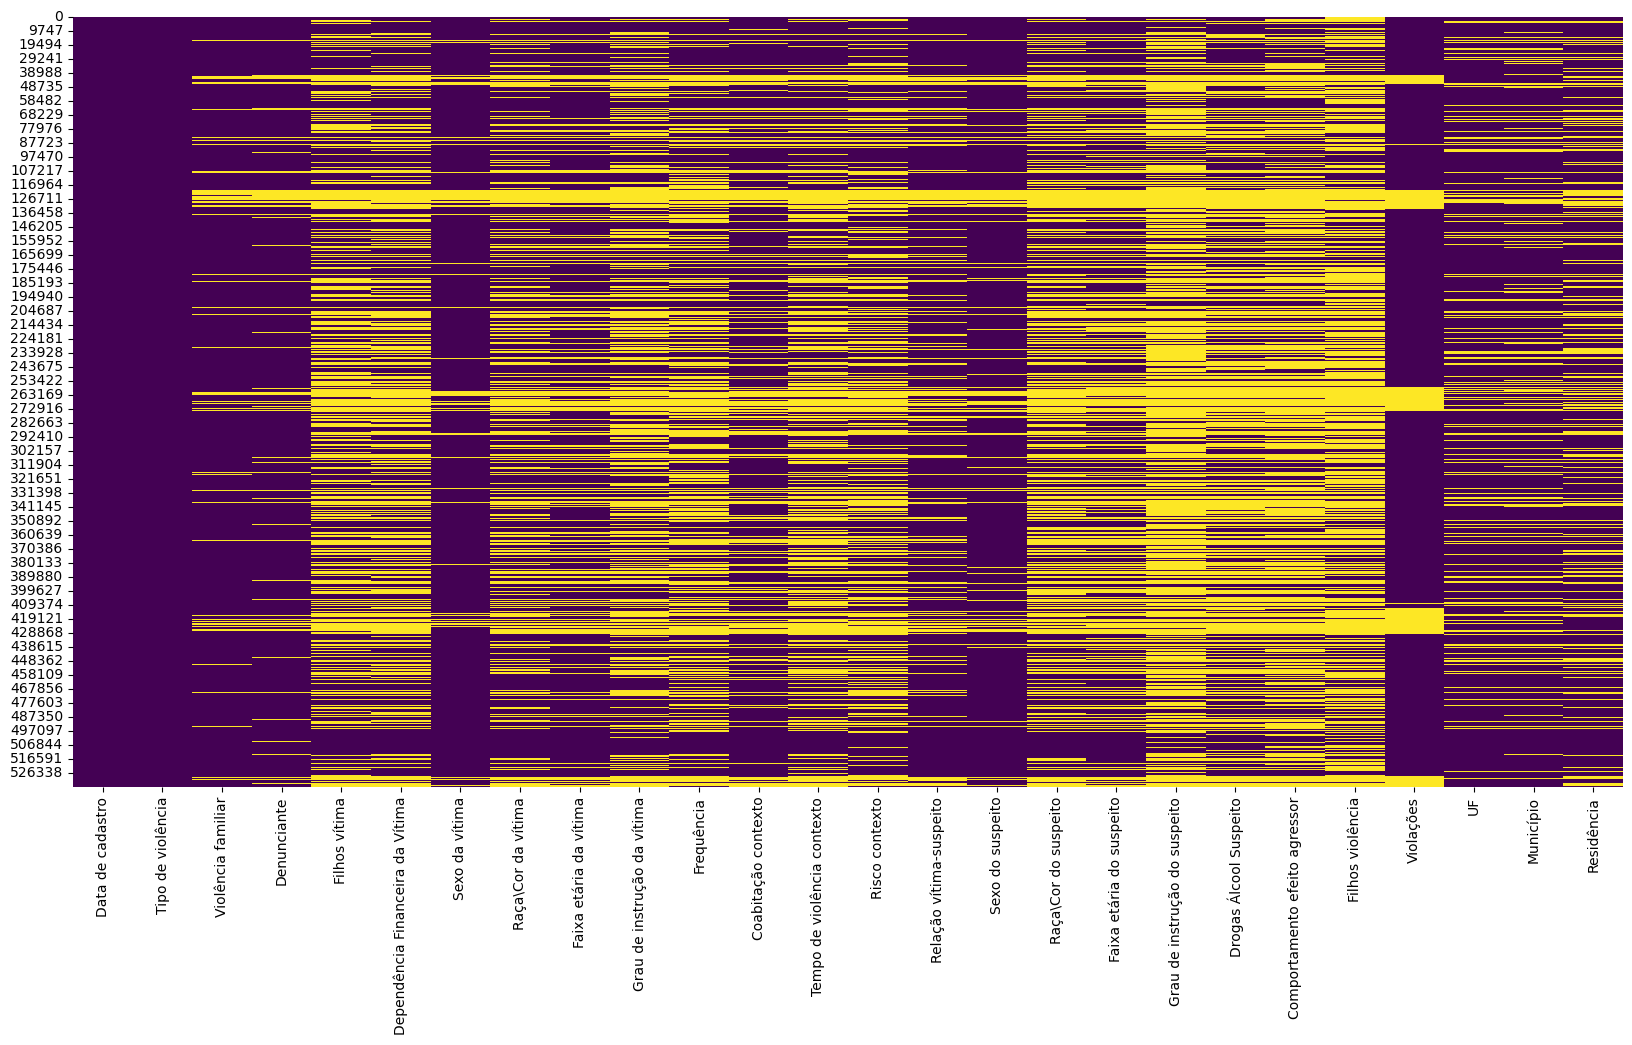

Linhas sem valores nulos: 70438/536041 (13.14%)


In [31]:
# Visualização dos valores nulos com um heatmap
plt.figure(figsize=(20, 10)) 
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.show()

numeroDeLinhasComNulo = data.isnull().any(axis=1).sum()
numeroDeLinhasSemNulo = data.notnull().all(axis=1).sum()
totalDeLinhas = len(data)
print(f"Linhas sem valores nulos: {numeroDeLinhasSemNulo}/{totalDeLinhas} ({numeroDeLinhasSemNulo/totalDeLinhas:.2%})")

In [34]:
data = data[data['UF'] == 'RS']

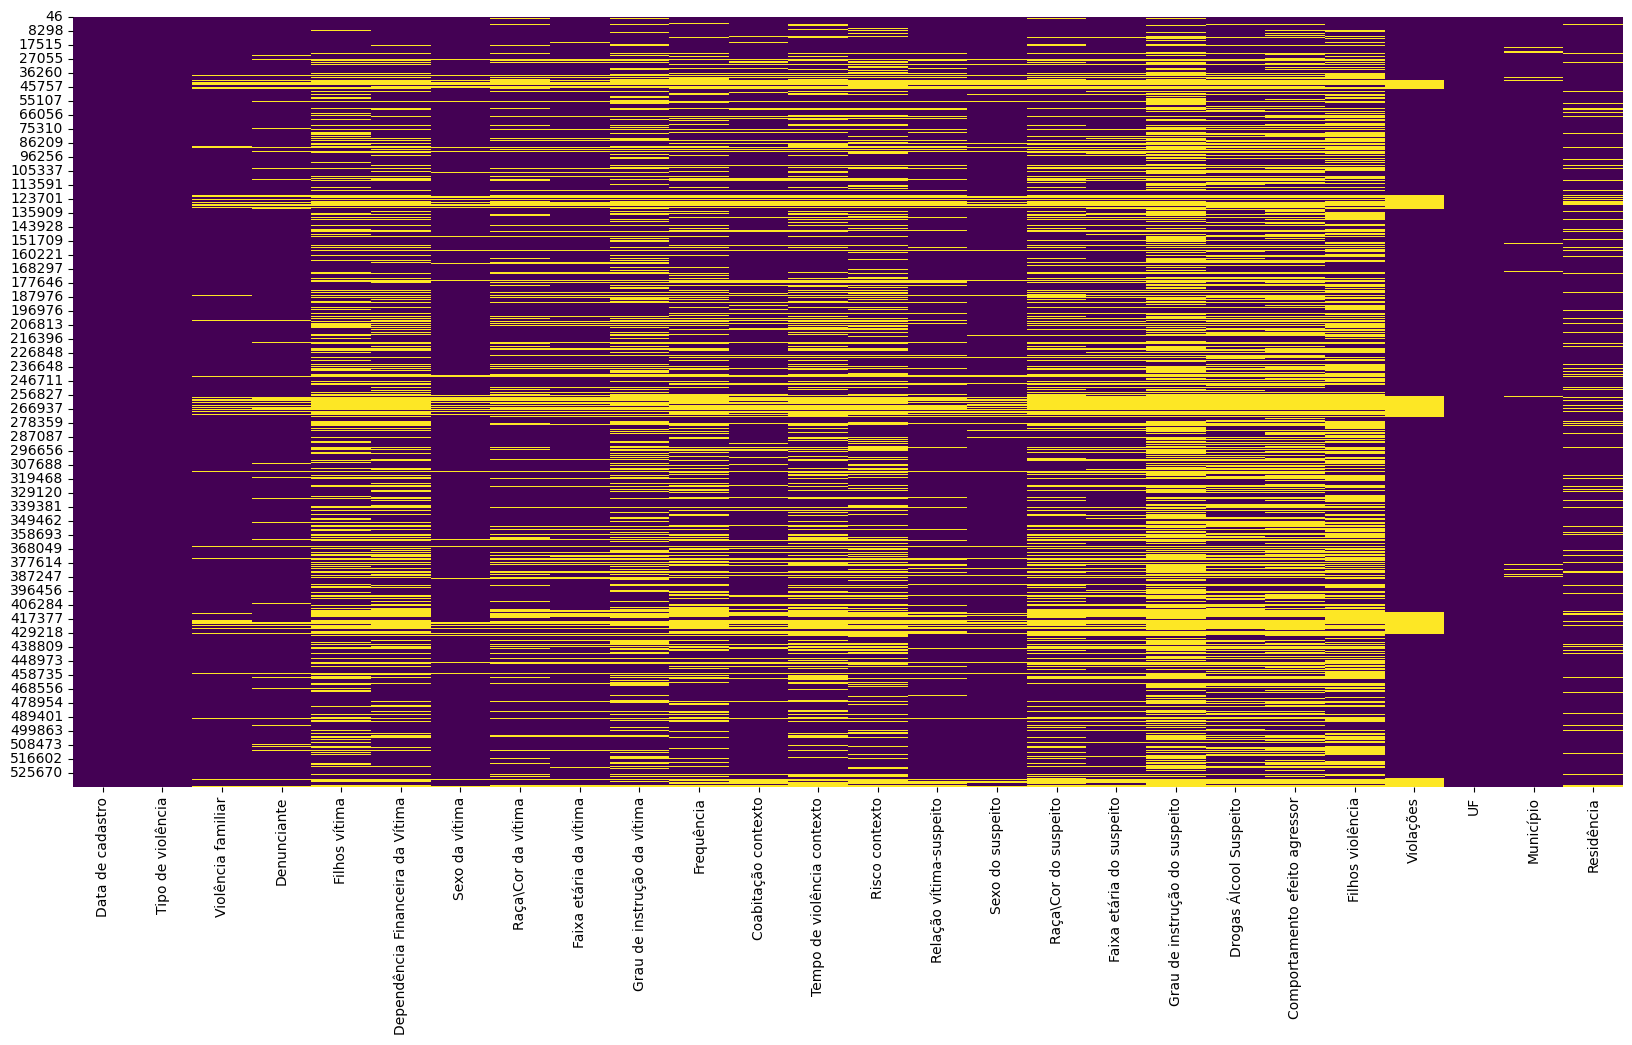

Linhas sem valores nulos: 4201/25180 (16.68%)


In [35]:
# Visualização dos valores nulos com um heatmap
plt.figure(figsize=(20, 10)) 
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.show()

numeroDeLinhasComNulo = data.isnull().any(axis=1).sum()
numeroDeLinhasSemNulo = data.notnull().all(axis=1).sum()
totalDeLinhas = len(data)
print(f"Linhas sem valores nulos: {numeroDeLinhasSemNulo}/{totalDeLinhas} ({numeroDeLinhasSemNulo/totalDeLinhas:.2%})")

# Escolha do Número de Clusters e Algoritmos de Inicialização 

A determinação do número adequado de clusters é fundamental para a preparação de modelos, principalmente para aqueles que utilizam métodos de clusterização que exigem a definição de uma quantidade préviamente, como o K-Modes e K-Means. 

O número de clusters pode, em alguns casos, ser facilmente determinado a partir do contexto de onde foram tirados os dados. Para dados de vendas de uma loja, por exemplo, o número de clusters pode ser referente ao número de produtos que a loja vende, de maneira que cada cluster representa o perfil do cliente que o consome. 

Se não, métodos como o Elbow Method, o Silhouette Score ou o Davies-Bouldin Index podem ajudar a estimar um número ótimo de clusters baseando-se na coesão interna dos clusters e na separação entre eles.

Aqui será usado o Elbow Method para encontrar um K (número de clusters) ótimo para nosso data set, com diferentes algoritmos de escolha para os valores iniciais de referência (modes) de cada cluster.

Todas as execuções serão feitas 5 vezes (n_init = 5) para garantir que não hajam tendências na geração de números aleatórios.

# Clusterização com K-Modes

1) https://pypi.org/project/kmodes/ 

2) https://harikabonthu96.medium.com/kmodes-clustering-2286a9bfdcfb

3) https://awari.com.br/aprenda-a-utilizar-o-k-modes-com-python-para-analise-de-dados/?utm_source=blog&utm_campaign=projeto+blog&utm_medium=Aprenda%20a%20Utilizar%20o%20K-Modes%20com%20Python%20para%20Análise%20de%20Dados

4) https://link.springer.com/article/10.1007/s00357-001-0004-3

## Teste 1

Clusterização usando todas as colunas com poucos valores únicos e removendo as linhas com pelo menos um nulo.

In [36]:
dataSelectedKModesTest1 = data[[
                                #'Data de cadastro',
                                'Tipo de violência',
                                'Violência familiar',
                                'Denunciante',
                                'Filhos vítima',
                                'Dependência Financeira da Vítima',
                                'Sexo da vítima',
                                'Raça\\Cor da vítima',
                                'Faixa etária da vítima',
                                'Grau de instrução da vítima',
                                'Frequência',
                                'Coabitação contexto',
                                'Tempo de violência contexto',
                                'Risco contexto',
                                'Relação vítima-suspeito',
                                'Sexo do suspeito',
                                'Raça\\Cor do suspeito',
                                'Faixa etária do suspeito',
                                'Grau de instrução do suspeito',
                                'Drogas Álcool Suspeito',
                                'Comportamento efeito agressor',
                                'Filhos violência',
                                #'Violações',
                                'UF',
                                #'Município',
                                'Residência'
                                ]].copy()

dataSelectedFilteredKModesTest1 = RemoveLinhasComNulos(dataSelectedKModesTest1)

# Definição de com quantos clusters será testado.
numbersOfClustersKModesTest1 = range(1,10)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Modes
costRandomTest1 = []
costCaoTest1 = []
costHuangTest1 = []

In [37]:
# Escolha aleatória dos modes (init = "random").
for clustersNumber in list(numbersOfClustersKModesTest1):
    kmode = KModes(n_clusters=clustersNumber, random_state=42, init = "random", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataSelectedFilteredKModesTest1)
    costRandomTest1.append(kmode.cost_)

Best run was number 1
Best run was number 1
Best run was number 3
Best run was number 4
Best run was number 2
Best run was number 2
Best run was number 2
Best run was number 2
Best run was number 2


In [38]:
# Modes escolhidos com base no algoritmo de Cao (init = "cao").
for clustersNumber in list(numbersOfClustersKModesTest1):
    kmode = KModes(n_clusters=clustersNumber, random_state=42, init = "cao", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataSelectedFilteredKModesTest1)
    costCaoTest1.append(kmode.cost_)

Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1


In [39]:
# Modes escolhidos com base no algoritmo de Huang (init = "huang").
for clustersNumber in list(numbersOfClustersKModesTest1):
    kmode = KModes(n_clusters=clustersNumber, random_state=42, init = "huang", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataSelectedFilteredKModesTest1)
    costHuangTest1.append(kmode.cost_)

Best run was number 1
Best run was number 3
Best run was number 4
Best run was number 4
Best run was number 1
Best run was number 1
Best run was number 4
Best run was number 1
Best run was number 3


In [40]:
costsKModesTest1 = pd.DataFrame({
    "Random" : costRandomTest1,
    "Cao" : costCaoTest1,
    "Huang" : costHuangTest1,
    "Número de Clusters" : numbersOfClustersKModesTest1
})

# Visualização dos custos
figKModesTest1 = px.line(
    costsKModesTest1, 
    x = "Número de Clusters", 
    y = ["Random", "Cao", "Huang"], 
    title = (
        f"Teste 1: Método do Cotovelo para o KModes com até {len(numbersOfClustersKModesTest1)} clusters. Dataset: {nomeDoArquivo}<br>"
        f"Linhas com nulo removidas. Colunas Data de Cadastro, Violações e Município removidas. Apenas RS."
    )
)

figKModesTest1.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Custo",
    legend_title="Método de Inicialização"
)

figKModesTest1.show()

In [41]:
modelKModesTest1 = KModes(n_clusters=4, random_state=42, init = "random", n_init = 5, verbose=1, n_jobs = -1)
modelKModesTest1.fit_predict(dataSelectedFilteredKModesTest1)

labelsKModesTest1 = modelKModesTest1.labels_

Best run was number 4


## Teste 2

Teste de clusterização sobre colunas especificas de perfil de vítima e suspeito, para as duas codificações. Colunas usadas:

 'Sexo da vítima',
 'Sexo do suspeito', 
 'Raça\Cor da vítima', 
 'Raça\Cor do suspeito',
 'Faixa etária da vítima', 
 'Faixa etária do suspeito',
 'Grau de instrução da vítima', 
 'Grau de instrução do suspeito'

In [42]:
# Seleciona as colunas que serão utilizadas
dataSelectedKModesTest2 = data[['Sexo da vítima',
                                'Sexo do suspeito',
                                'Raça\\Cor da vítima',
                                'Raça\\Cor do suspeito',
                                'Faixa etária da vítima',
                                'Faixa etária do suspeito',
                                'Grau de instrução da vítima',
                                'Grau de instrução do suspeito']].copy()

dataSelectedFilteredKModesTest2 = RemoveLinhasComNulos(dataSelectedKModesTest2)

# Definição de com quantos clusters será testado.
numbersOfClustersKModesTest2 = range(1,10)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Modes
costRandomTest2 = []
costCaoTest2 = []
costHuangTest2 = []

In [43]:
# Escolha aleatória dos modes (init = "random").
for clustersNumber in list(numbersOfClustersKModesTest2):
    kmode = KModes(n_clusters=clustersNumber, random_state=42, init = "random", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataSelectedFilteredKModesTest2)
    costRandomTest2.append(kmode.cost_)

Best run was number 1
Best run was number 4
Best run was number 4
Best run was number 4
Best run was number 4
Best run was number 3
Best run was number 3
Best run was number 3
Best run was number 5


In [44]:
# Modes escolhidos com base no algoritmo de Cao (init = "cao").
for clustersNumber in list(numbersOfClustersKModesTest2):
    kmode = KModes(n_clusters=clustersNumber, random_state=42, init = "cao", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataSelectedFilteredKModesTest2)
    costCaoTest2.append(kmode.cost_)

Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1


In [45]:
# Modes escolhidos com base no algoritmo de Huang (init = "huang").
for clustersNumber in list(numbersOfClustersKModesTest2):
    kmode = KModes(n_clusters=clustersNumber, random_state=42, init = "huang", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataSelectedFilteredKModesTest2)
    costHuangTest2.append(kmode.cost_)

Best run was number 1
Best run was number 4
Best run was number 1
Best run was number 1
Best run was number 2
Best run was number 1
Best run was number 5
Best run was number 2
Best run was number 3


In [46]:
costsKModesTest2 = pd.DataFrame({
    "Random" : costRandomTest2,
    "Cao" : costCaoTest2,
    "Huang" : costHuangTest2,
    "Número de Clusters" : numbersOfClustersKModesTest2
})

# Visualização dos custos
figKModesTest2 = px.line(
    costsKModesTest2, 
    x = "Número de Clusters", 
    y = ["Random", "Cao", "Huang"], 
    title = (
        f"Teste 2: Método do Cotovelo para o KModes com até {len(numbersOfClustersKModesTest2)} clusters. Dataset: {nomeDoArquivo}<br>"
        f"Linhas com nulo removidas. Colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução (vítima e suspeito). Apenas RS."
    )
)

figKModesTest2.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Custo",
    legend_title="Método de Inicialização"
)

figKModesTest2.show()

In [47]:
modelKModesTest2 = KModes(n_clusters=4, random_state=42, init = "random", n_init = 5, verbose=1, n_jobs = -1)
modelKModesTest2.fit_predict(dataSelectedFilteredKModesTest2)

labelsKModesTest2 = modelKModesTest2.labels_

Best run was number 4


## Teste 3

Teste de clusterização sobre colunas especificas de perfil apenas da vítima para as duas codificações. Colunas usadas:

 'Sexo da vítima', 
 'Raça\Cor da vítima',
 'Faixa etária da vítima', 
 'Grau de instrução da vítima', 


In [48]:
# Seleciona as colunas que serão utilizadas
dataSelectedKModesTest3 = data[['Sexo da vítima',
                                'Raça\\Cor da vítima',
                                'Faixa etária da vítima',
                                'Grau de instrução da vítima']].copy()

dataSelectedFilteredKModesTest3 = RemoveLinhasComNulos(dataSelectedKModesTest3)

# Definição de com quantos clusters será testado.
numbersOfClustersKModesTest3 = range(1,10)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Modes
costRandomTest3 = []
costCaoTest3 = []
costHuangTest3 = []

In [49]:
# Escolha aleatória dos modes (init = "random").
for clustersNumber in list(numbersOfClustersKModesTest3):
    kmode = KModes(n_clusters=clustersNumber, random_state=42, init = "random", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataSelectedFilteredKModesTest3)
    costRandomTest3.append(kmode.cost_)

Best run was number 1
Best run was number 3
Best run was number 1
Best run was number 3
Best run was number 1
Best run was number 1
Best run was number 5
Best run was number 2
Best run was number 2


In [50]:
# Modes escolhidos com base no algoritmo de Cao (init = "cao").
for clustersNumber in list(numbersOfClustersKModesTest3):
    kmode = KModes(n_clusters=clustersNumber, random_state=42, init = "cao", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataSelectedFilteredKModesTest3)
    costCaoTest3.append(kmode.cost_)

Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1


In [51]:
# Modes escolhidos com base no algoritmo de Huang (init = "huang").
for clustersNumber in list(numbersOfClustersKModesTest3):
    kmode = KModes(n_clusters=clustersNumber, random_state=42, init = "huang", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataSelectedFilteredKModesTest3)
    costHuangTest3.append(kmode.cost_)

Best run was number 1
Best run was number 5
Best run was number 1
Best run was number 2
Best run was number 2
Best run was number 2
Best run was number 5
Best run was number 1
Best run was number 5


In [52]:
costsKModesTest3 = pd.DataFrame({
    "Random" : costRandomTest3,
    "Cao" : costCaoTest3,
    "Huang" : costHuangTest3,
    "Número de Clusters" : numbersOfClustersKModesTest3
})

# Visualização dos custos
figKModesTest3 = px.line(
    costsKModesTest3, 
    x = "Número de Clusters", 
    y = ["Random", "Cao", "Huang"], 
    title = (
        f"Teste 3: Método do Cotovelo para o KModes com até {len(numbersOfClustersKModesTest3)} clusters. Dataset: {nomeDoArquivo}<br>"
        f"Linhas com nulo removidas. Colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução (apenas de vítimas). Apenas RS."
    )
)

figKModesTest3.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Custo",
    legend_title="Método de Inicialização"
)

figKModesTest3.show()

In [53]:
modelKModesTest3 = KModes(n_clusters=4, random_state=42, init = "random", n_init = 5, verbose=1, n_jobs = -1)
modelKModesTest3.fit_predict(dataSelectedFilteredKModesTest3)

labelsKModesTest3 = modelKModesTest3.labels_

Best run was number 3


## Teste 4

Teste de clusterização sobre colunas especificas de perfil do suspeito, para as duas codificações. Colunas usadas:

 'Sexo do suspeito',
 'Raça\Cor do suspeito', 
 'Faixa etária do suspeito', 
 'Grau de instrução do suspeito'

In [54]:
# Seleciona as colunas que serão utilizadas
dataSelectedKModesTest4 = data[['Sexo do suspeito',
                                'Raça\\Cor do suspeito',
                                'Faixa etária do suspeito',
                                'Grau de instrução do suspeito']].copy()

dataSelectedFilteredKModesTest4 = RemoveLinhasComNulos(dataSelectedKModesTest4)

# Definição de com quantos clusters será testado.
numbersOfClustersKModesTest4 = range(1,10)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Modes
costRandomTest4 = []
costCaoTest4 = []
costHuangTest4 = []

In [55]:
# Escolha aleatória dos modes (init = "random").
for clustersNumber in list(numbersOfClustersKModesTest4):
    kmode = KModes(n_clusters=clustersNumber, init = "random", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataSelectedFilteredKModesTest4)
    costRandomTest4.append(kmode.cost_)

Best run was number 1
Best run was number 1
Best run was number 5
Best run was number 2
Best run was number 2
Best run was number 4
Best run was number 4
Best run was number 5
Best run was number 2


In [56]:
# Modes escolhidos com base no algoritmo de Cao (init = "cao").
for clustersNumber in list(numbersOfClustersKModesTest4):
    kmode = KModes(n_clusters=clustersNumber, init = "cao", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataSelectedFilteredKModesTest4)
    costCaoTest4.append(kmode.cost_)

Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1
Best run was number 1


In [57]:
# Modes escolhidos com base no algoritmo de Huang (init = "huang").
for clustersNumber in list(numbersOfClustersKModesTest4):
    kmode = KModes(n_clusters=clustersNumber, init = "huang", n_init = 5, verbose=1, n_jobs = -1)
    kmode.fit_predict(dataSelectedFilteredKModesTest4)
    costHuangTest4.append(kmode.cost_)

Best run was number 1
Best run was number 4
Best run was number 1
Best run was number 5
Best run was number 5
Best run was number 1
Best run was number 4
Best run was number 2
Best run was number 5


In [58]:
costsKModesTest4 = pd.DataFrame({
    "Random" : costRandomTest4,
    "Cao" : costCaoTest4,
    "Huang" : costHuangTest4,
    "Número de Clusters" : numbersOfClustersKModesTest4
})

# Visualização dos custos
figKModesTest4 = px.line(
    costsKModesTest4, 
    x = "Número de Clusters", 
    y = ["Random", "Cao", "Huang"], 
    title = (
        f"Teste 4: Método do Cotovelo para o KModes com até {len(numbersOfClustersKModesTest4)} clusters. Dataset: {nomeDoArquivo}<br>"
        f"Linhas com nulo removidas. Colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução (apenas de suspeitos). Apenas RS."
    )
)

figKModesTest4.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Custo",
    legend_title="Método de Inicialização"
)

figKModesTest4.show()

In [59]:
modelKModesTest4 = KModes(n_clusters=4, random_state=42, init = "random", n_init = 5, verbose=1, n_jobs = -1)
modelKModesTest4.fit_predict(dataSelectedFilteredKModesTest4)

labelsKModesTest4 = modelKModesTest4.labels_

Best run was number 1


# Clusterização com K-Means

## Teste 1

Clusterização usando todas as colunas com poucos valores únicos e removendo as linhas com pelo menos um nulo.

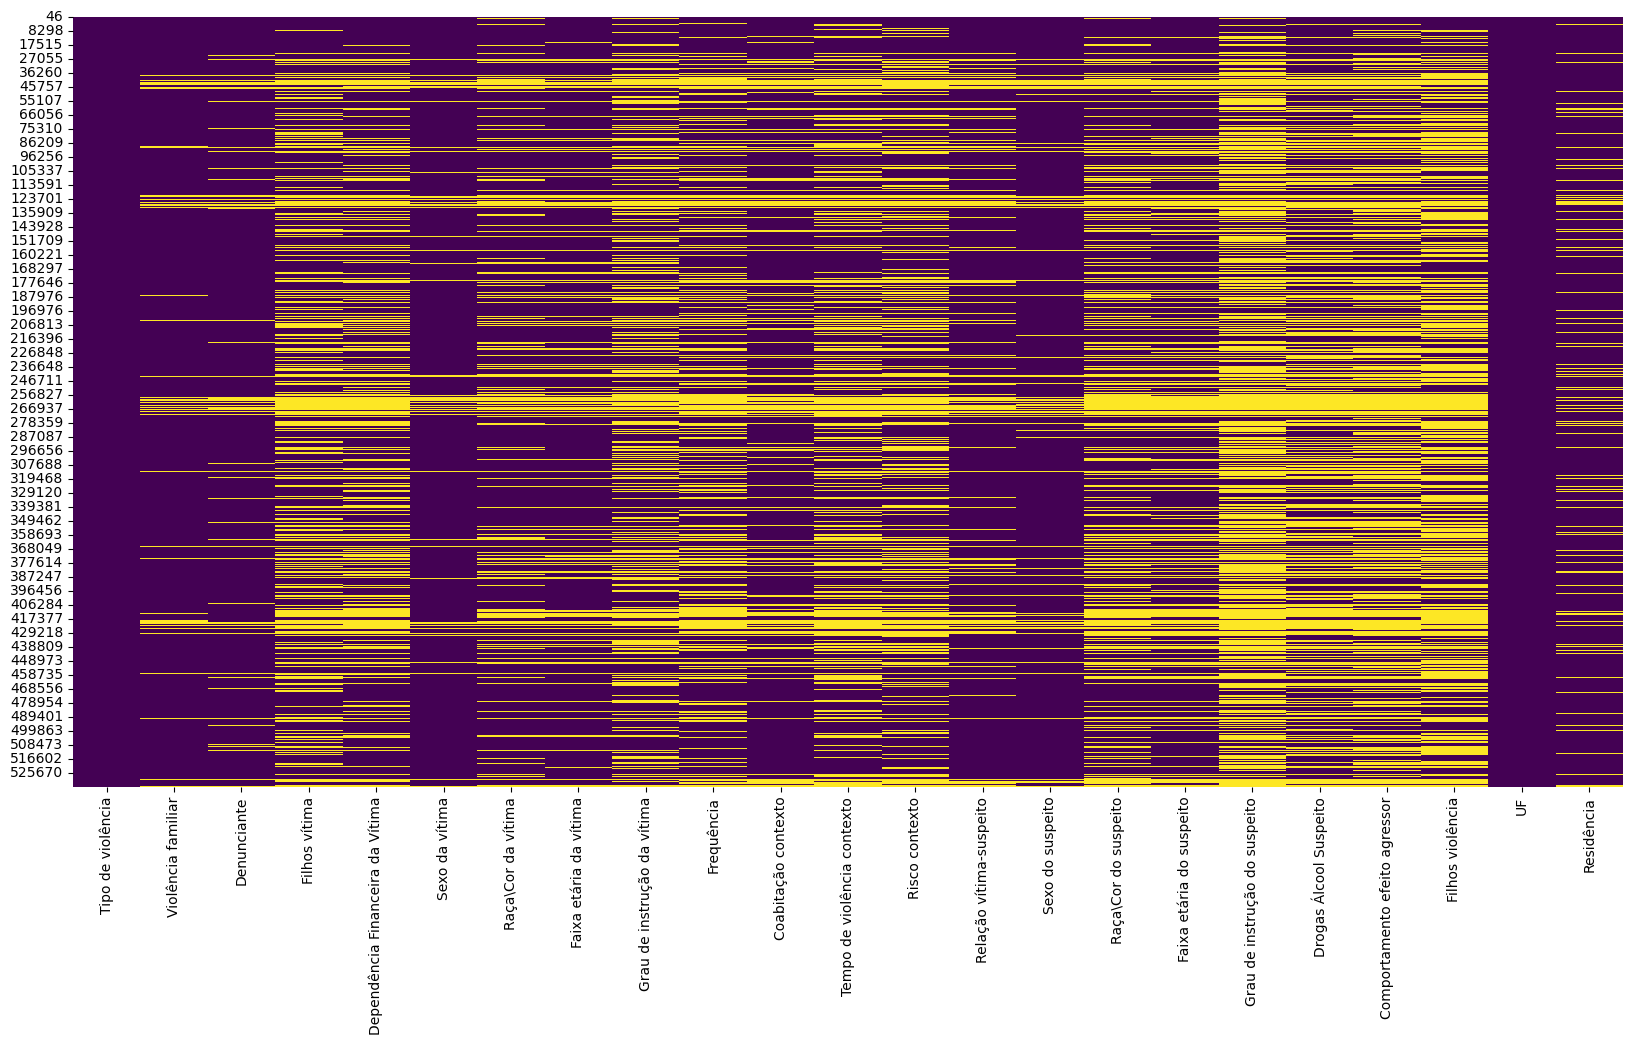

Linhas sem valores nulos: 4324/25180 (17.17%)


In [60]:
dataSelectedKMeansTest1 = data[[
                     #'Data de cadastro',
                     'Tipo de violência',
                     'Violência familiar',
                     'Denunciante',
                     'Filhos vítima',
                     'Dependência Financeira da Vítima',
                     'Sexo da vítima',
                     'Raça\\Cor da vítima',
                     'Faixa etária da vítima',
                     'Grau de instrução da vítima',
                     'Frequência',
                     'Coabitação contexto',
                     'Tempo de violência contexto',
                     'Risco contexto',
                     'Relação vítima-suspeito',
                     'Sexo do suspeito',
                     'Raça\\Cor do suspeito',
                     'Faixa etária do suspeito',
                     'Grau de instrução do suspeito',
                     'Drogas Álcool Suspeito',
                     'Comportamento efeito agressor',
                     'Filhos violência',
                     #'Violações',
                     'UF',
                     #'Município',
                     'Residência'
                    ]].copy()

# Visualização dos valores nulos com um heatmap
plt.figure(figsize=(20, 10)) 
sns.heatmap(dataSelectedKMeansTest1.isnull(), cbar=False, cmap='viridis')
plt.show()

numeroDeLinhasComNulo = dataSelectedKMeansTest1.isnull().any(axis=1).sum()
numeroDeLinhasSemNulo = dataSelectedKMeansTest1.notnull().all(axis=1).sum()
totalDeLinhas = len(dataSelectedKMeansTest1)
print(f"Linhas sem valores nulos: {numeroDeLinhasSemNulo}/{totalDeLinhas} ({numeroDeLinhasSemNulo/totalDeLinhas:.2%})")

# Remove as linhas com valores nulos
dataSelectedKMeansTest1 = RemoveLinhasComNulos(dataSelectedKMeansTest1)

### Teste 1.1

**Codificação**: Binária

In [61]:
# Aplica a codificação Binária
codificador = ce.BinaryEncoder(cols=dataSelectedKMeansTest1.columns)
dataSelectedEncodedBinaryKMeansTest1_1 = codificador.fit_transform(dataSelectedKMeansTest1) 

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest1_1 = range(1, 10)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest1_1 = []
inertiaKMeansTest1_1 = []

In [62]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest1_1:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataSelectedEncodedBinaryKMeansTest1_1)
    inertiaRandomTest1_1.append(kmeans_random.inertia_)

In [63]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest1_1:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataSelectedEncodedBinaryKMeansTest1_1)
    inertiaKMeansTest1_1.append(kmeans_kmeans.inertia_)

In [64]:
inertiasKMeansTest1_1 = pd.DataFrame({
    "Random" : inertiaRandomTest1_1,
    "K-Means++" : inertiaKMeansTest1_1,
    "Número de Clusters" : numbersOfClustersKMeansTest1_1
})

# Visualização dos custos
figKMeansTest1_1 = px.line(
    inertiasKMeansTest1_1, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 1.1: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest1_1)} clusters. Dataset: {nomeDoArquivo}. Codificação: binária.<br>"
        f"Linhas com nulo removidas. Colunas Data de Cadastro, Violações e Município removidas. Apenas RS."
    )
)

figKMeansTest1_1.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização"
)

figKMeansTest1_1.show()

In [65]:
modelKMeansTest1_1 = KMeans(n_clusters=4, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
modelKMeansTest1_1.fit(dataSelectedEncodedBinaryKMeansTest1_1)

labelsKMeansTest1_1 = modelKMeansTest1_1.labels_

### Teste 1.2

**Codificação**: One-Hot

In [66]:
# Aplica a codificação One-Hot
dataSelectedEncodedOneHotKMeansTest1_2 = pd.get_dummies(dataSelectedKMeansTest1)

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest1_2 = range(1, 10)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest1_2 = []
inertiaKMeansTest1_2 = []

In [67]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest1_2:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataSelectedEncodedOneHotKMeansTest1_2)
    inertiaRandomTest1_2.append(kmeans_random.inertia_)

In [68]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest1_2:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataSelectedEncodedOneHotKMeansTest1_2)
    inertiaKMeansTest1_2.append(kmeans_kmeans.inertia_)

In [69]:
inertiasKMeansTest1_2 = pd.DataFrame({
    "Random" : inertiaRandomTest1_2,
    "K-Means++" : inertiaKMeansTest1_2,
    "Número de Clusters" : numbersOfClustersKMeansTest1_2
})

# Visualização dos custos
figKMeansTest1_2 = px.line(
    inertiasKMeansTest1_2, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 1.2: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest1_2)} clusters. Dataset: {nomeDoArquivo}. Codificação: One-Hot.<br>"
        f"Linhas com nulo removidas. Colunas Data de Cadastro, Violações e Município removidas. Apenas RS."
    )
)

figKMeansTest1_2.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização"
)

figKMeansTest1_2.show()

In [70]:
modelKMeansTest1_2 = KMeans(n_clusters=4, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
modelKMeansTest1_2.fit(dataSelectedEncodedOneHotKMeansTest1_2)

labelsKMeansTest1_2 = modelKMeansTest1_2.labels_

## Teste 2

Teste de clusterização sobre colunas especificas de perfil de vítima e suspeito, para as duas codificações. Colunas usadas:

 'Sexo da vítima',
 'Sexo do suspeito', 
 'Raça\Cor da vítima', 
 'Raça\Cor do suspeito',
 'Faixa etária da vítima', 
 'Faixa etária do suspeito',
 'Grau de instrução da vítima', 
 'Grau de instrução do suspeito'

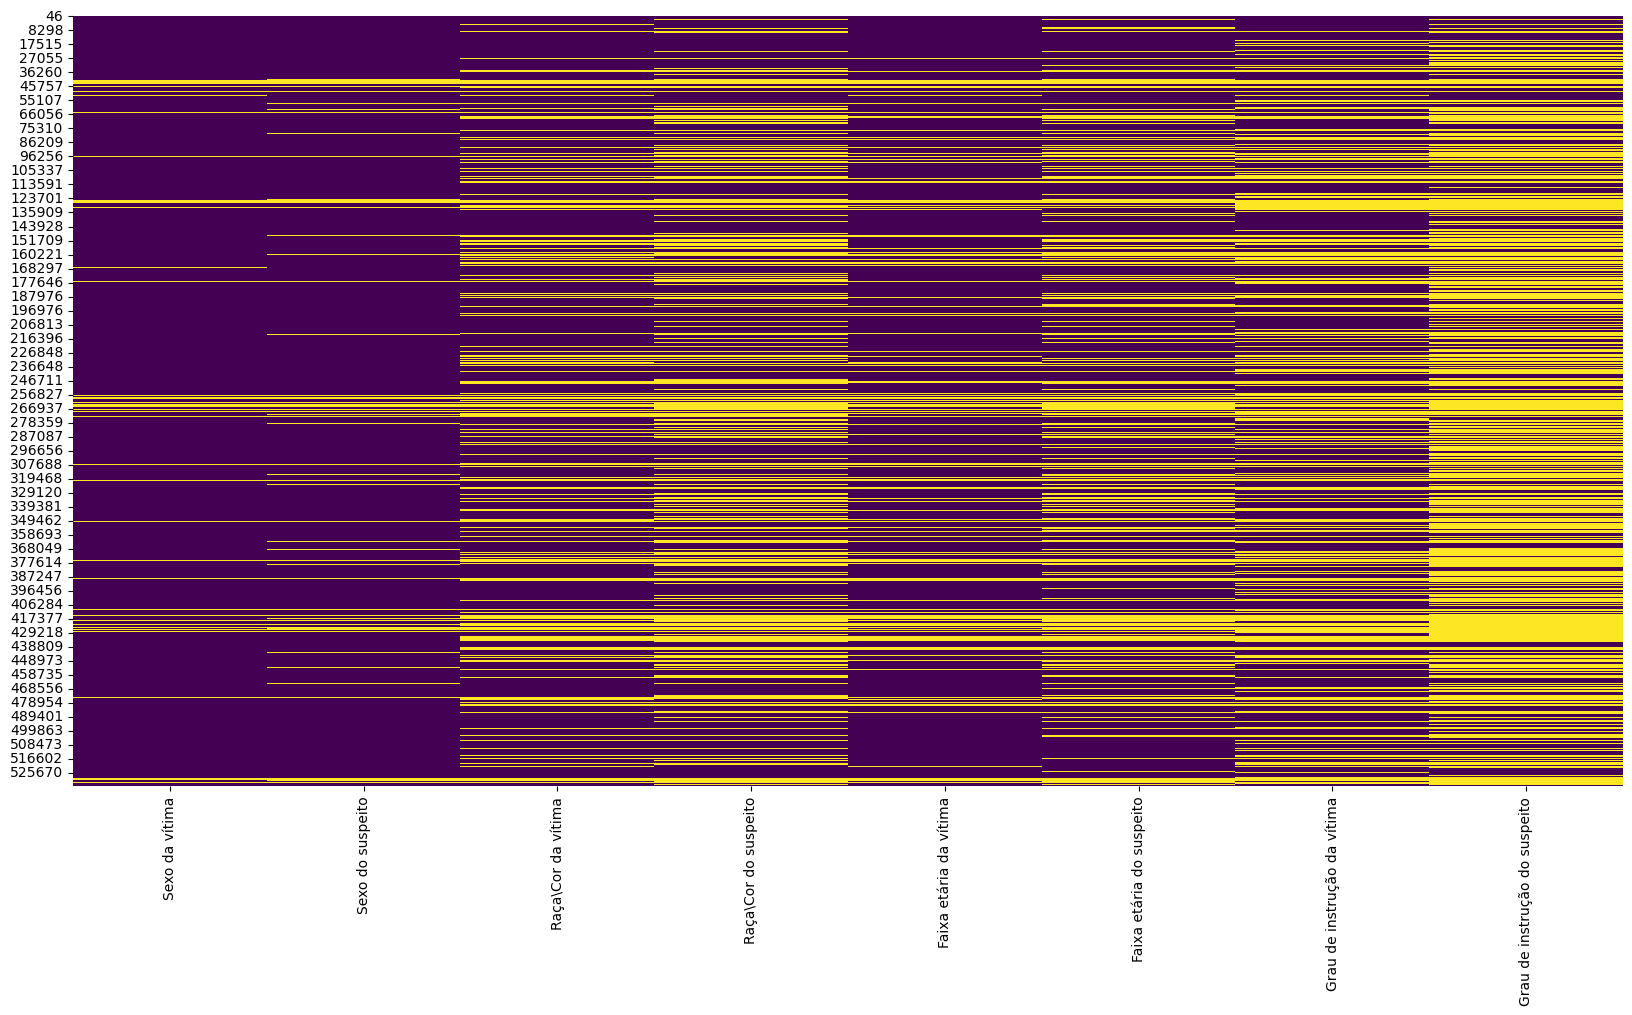

Linhas sem valores nulos: 9314/25180 (36.99%)


In [71]:
# Seleciona as colunas que serão utilizadas
dataSelectedKMeansTest2 = data[['Sexo da vítima',
                                'Sexo do suspeito',
                                'Raça\\Cor da vítima',
                                'Raça\\Cor do suspeito',
                                'Faixa etária da vítima',
                                'Faixa etária do suspeito',
                                'Grau de instrução da vítima',
                                'Grau de instrução do suspeito']].copy()

# Visualização dos valores nulos com um heatmap
plt.figure(figsize=(20, 10)) 
sns.heatmap(dataSelectedKMeansTest2.isnull(), cbar=False, cmap='viridis')
plt.show()

numeroDeLinhasComNulo = dataSelectedKMeansTest2.isnull().any(axis=1).sum()
numeroDeLinhasSemNulo = dataSelectedKMeansTest2.notnull().all(axis=1).sum()
totalDeLinhas = len(dataSelectedKMeansTest2)
print(f"Linhas sem valores nulos: {numeroDeLinhasSemNulo}/{totalDeLinhas} ({numeroDeLinhasSemNulo/totalDeLinhas:.2%})")

# Remove as linhas com valores nulos
dataSelectedKMeansTest2 = RemoveLinhasComNulos(dataSelectedKMeansTest2)

### Teste 2.1

**Codificação**: Binária

In [72]:
# Aplica a codificação Binária
codificador = ce.BinaryEncoder(cols=dataSelectedKMeansTest2.columns)
dataSelectedEncodedBinaryKMeansTest2_1 = codificador.fit_transform(dataSelectedKMeansTest2) 

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest2_1 = range(1, 10)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest2_1 = []
inertiaKMeansTest2_1 = []

In [73]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest2_1:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataSelectedEncodedBinaryKMeansTest2_1)
    inertiaRandomTest2_1.append(kmeans_random.inertia_)

In [74]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest2_1:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataSelectedEncodedBinaryKMeansTest2_1)
    inertiaKMeansTest2_1.append(kmeans_kmeans.inertia_)

In [75]:
inertiasKMeansTest2_1 = pd.DataFrame({
    "Random" : inertiaRandomTest2_1,
    "K-Means++" : inertiaKMeansTest2_1,
    "Número de Clusters" : numbersOfClustersKMeansTest2_1
})

# Visualização dos custos
figKMeansTest2_1 = px.line(
    inertiasKMeansTest2_1, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 2.1: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest2_1)} clusters. Dataset: {nomeDoArquivo}. Codificação: binária.<br>"
        f"Linhas com nulo removidas. Colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução (vítima e suspeito). Apenas RS."
    )
)

figKMeansTest2_1.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização"
)

figKMeansTest2_1.show()

In [76]:
modelKMeansTest2_1 = KMeans(n_clusters=4, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
modelKMeansTest2_1.fit(dataSelectedEncodedBinaryKMeansTest2_1)

labelsKMeansTest2_1 = modelKMeansTest2_1.labels_

### Teste 2.2

**Codificação**: One-Hot

In [77]:
# Aplica a codificação One-Hot
dataSelectedEncodedOneHotKMeansTest2_2 = pd.get_dummies(dataSelectedKMeansTest2)

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest2_2 = range(1, 10)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest2_2 = []
inertiaKMeansTest2_2 = []

In [78]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest2_2:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataSelectedEncodedOneHotKMeansTest2_2)
    inertiaRandomTest2_2.append(kmeans_random.inertia_)

In [79]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest2_2:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataSelectedEncodedOneHotKMeansTest2_2)
    inertiaKMeansTest2_2.append(kmeans_kmeans.inertia_)

In [80]:
inertiasKMeansTest2_2 = pd.DataFrame({
    "Random" : inertiaRandomTest2_2,
    "K-Means++" : inertiaKMeansTest2_2,
    "Número de Clusters" : numbersOfClustersKMeansTest2_2
})

# Visualização dos custos
figKMeansTest2_2 = px.line(
    inertiasKMeansTest2_2, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 2.2: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest2_2)} clusters. Dataset: {nomeDoArquivo}. Codificação: One-Hot.<br>"
        f"Linhas com nulo removidas. Colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução (vítima e suspeito). Apenas RS."
    )
)

figKMeansTest2_2.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização"
)

figKMeansTest2_2.show()

In [81]:
modelKMeansTest2_2 = KMeans(n_clusters=4, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
modelKMeansTest2_2.fit(dataSelectedEncodedOneHotKMeansTest2_2)

labelsKMeansTest2_2 = modelKMeansTest2_2.labels_

## Teste 3

Teste de clusterização sobre colunas especificas de perfil apenas da vítima para as duas codificações. Colunas usadas:

 'Sexo da vítima', 
 'Raça\Cor da vítima',
 'Faixa etária da vítima', 
 'Grau de instrução da vítima', 


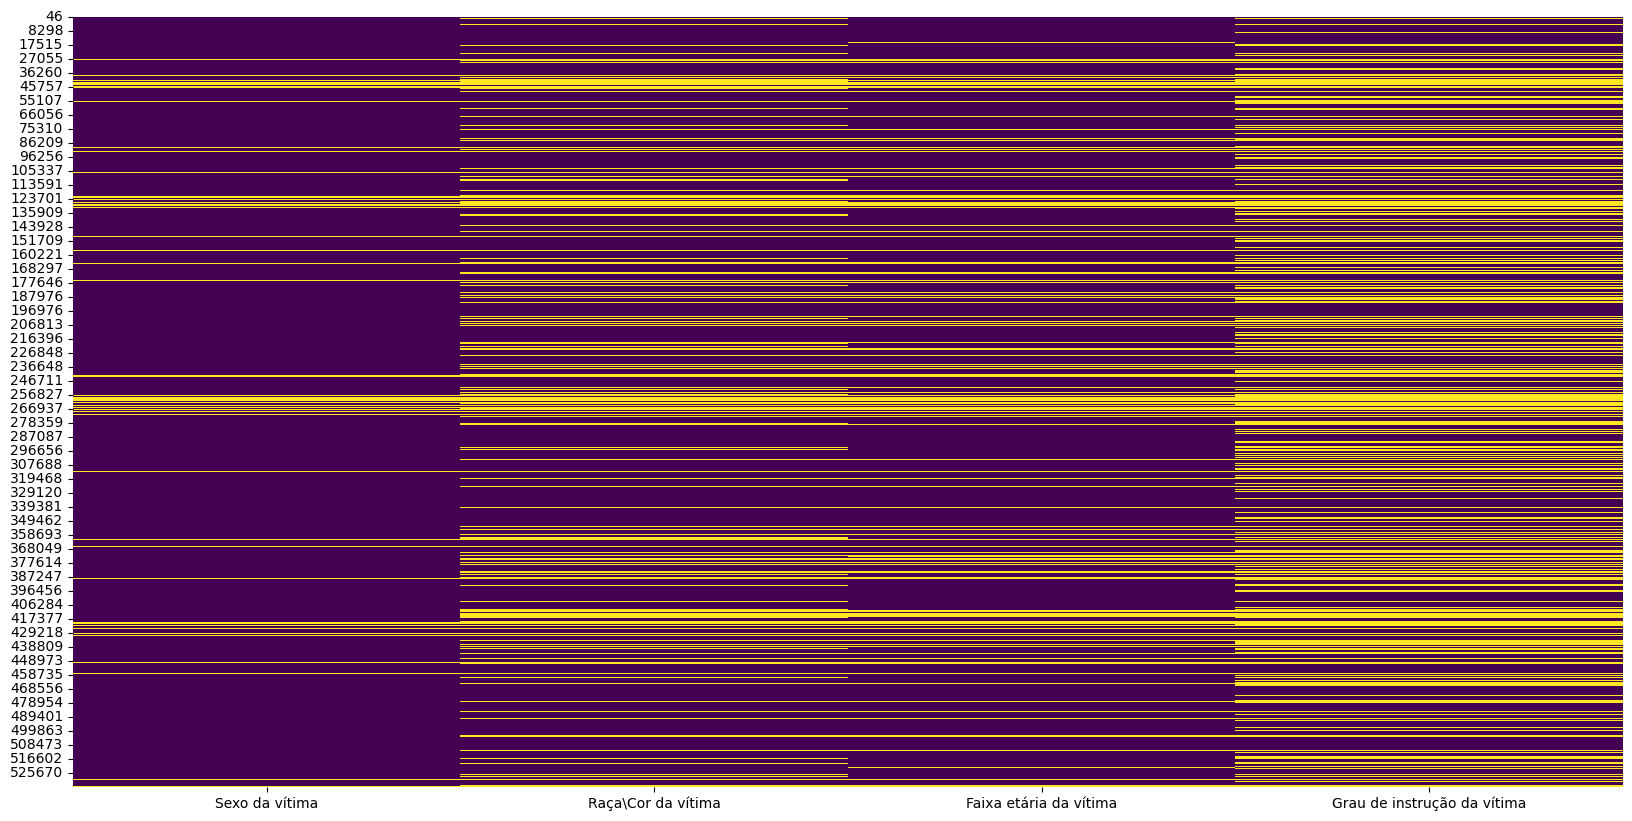

Linhas sem valores nulos: 15982/25180 (63.47%)


In [82]:
# Seleciona as colunas que serão utilizadas
dataSelectedKMeansTest3 = data[['Sexo da vítima',
                                'Raça\\Cor da vítima',
                                'Faixa etária da vítima',
                                'Grau de instrução da vítima']].copy()

# Visualização dos valores nulos com um heatmap
plt.figure(figsize=(20, 10)) 
sns.heatmap(dataSelectedKMeansTest3.isnull(), cbar=False, cmap='viridis')
plt.show()

numeroDeLinhasComNulo = dataSelectedKMeansTest3.isnull().any(axis=1).sum()
numeroDeLinhasSemNulo = dataSelectedKMeansTest3.notnull().all(axis=1).sum()
totalDeLinhas = len(dataSelectedKMeansTest3)
print(f"Linhas sem valores nulos: {numeroDeLinhasSemNulo}/{totalDeLinhas} ({numeroDeLinhasSemNulo/totalDeLinhas:.2%})")

# Remove as linhas com valores nulos
dataSelectedKMeansTest3 = RemoveLinhasComNulos(dataSelectedKMeansTest3)

### Teste 3.1

**Codificação:** Binária

In [83]:
# Aplica a codificação Binária
codificador = ce.BinaryEncoder(cols=dataSelectedKMeansTest3.columns)
dataSelectedEncodedBinaryKMeansTest3_1 = codificador.fit_transform(dataSelectedKMeansTest3) 

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest3_1 = range(1, 10)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest3_1 = []
inertiaKMeansTest3_1 = []

In [84]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest3_1:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataSelectedEncodedBinaryKMeansTest3_1)
    inertiaRandomTest3_1.append(kmeans_random.inertia_)

In [85]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest3_1:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataSelectedEncodedBinaryKMeansTest3_1)
    inertiaKMeansTest3_1.append(kmeans_kmeans.inertia_)

In [86]:
inertiasKMeansTest3_1 = pd.DataFrame({
    "Random" : inertiaRandomTest3_1,
    "K-Means++" : inertiaKMeansTest3_1,
    "Número de Clusters" : numbersOfClustersKMeansTest3_1
})

# Visualização dos custos
figKMeansTest3_1 = px.line(
    inertiasKMeansTest3_1, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 3.1: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest3_1)} clusters. Dataset: {nomeDoArquivo}. Codificação: binária.  <br>"
        f"Linhas com nulo removidas. Colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução (apenas vítima). Apenas RS."
    )
)

figKMeansTest3_1.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização",
)

figKMeansTest3_1.show()

In [87]:
modelKMeansTest3_1 = KMeans(n_clusters=4, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
modelKMeansTest3_1.fit(dataSelectedEncodedBinaryKMeansTest3_1)

labelsKMeansTest3_1 = modelKMeansTest3_1.labels_

In [88]:
## Aplica a clusterização com 4 clusters
#kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10, max_iter=300)
#kmeans.fit(dataSelectedEncodedBinaryKMeansTest3_1)
#
## Adiciona os labels dos clusters ao dataset original
#dataSelectedKMeansTest3['Cluster'] = kmeans.labels_

In [89]:
# Criação de um gráfico 3D para visualização dos clusters
#fig = px.scatter_3d(dataSelectedTest3_1,
#                    x='Faixa etária da vítima',
#                    y='Raça\\Cor da vítima',
#                    z='Grau de instrução da vítima',
#                    color='Cluster',
#                    title='Visualização 3D dos Clusters (Faixa Etária, Grau de Instrução e Raça\\Cor da Vítima)',
#                    labels={'Cluster': 'Cluster'})
#
#fig.show()

In [90]:
# Inicializando o app Dash
#app = dash.Dash(__name__)
#
## Função para criar gráficos
#def create_bar_chart(data):
#    faixaEtariaCluster = data.groupby(['Faixa etária da vítima', 'Cluster']).size().reset_index(name='Count')
#    return px.bar(faixaEtariaCluster, 
#                  x='Faixa etária da vítima', 
#                  y='Count', 
#                  color='Cluster', 
#                  barmode='group', 
#                  title='Distribuição da Faixa Etária da Vítima por Cluster')
#
#def create_scatter_plot(data):
#    return px.scatter(data, 
#                      x='Faixa etária da vítima', 
#                      y='Grau de instrução da vítima', 
#                      color='Cluster', 
#                      title='Relação entre Faixa Etária e Grau de Instrução por Cluster',
#                      labels={'Faixa etária da vítima': 'Faixa Etária', 'Grau de instrução da vítima': 'Grau de Instrução'})
#
#def create_heatmap(data):
#    heatmap_data = pd.crosstab([data['Faixa etária da vítima'], data['Raça\\Cor da vítima']], data['Cluster'], normalize='index')
#    return px.imshow(heatmap_data, 
#                     title='Distribuição de Faixa Etária e Raça/Cor da Vítima por Cluster',
#                     labels={'x': 'Cluster', 'y': 'Faixa etária e Raça/Cor da Vítima'},
#                     color_continuous_scale='Viridis')
#
## Layout do dashboard
#app.layout = html.Div([
#    html.H1("Dashboard de Análise de Clusters"),
#
#    # Primeiro gráfico - Gráfico de Barras
#    dcc.Graph(id='bar-chart', figure=create_bar_chart(dataSelectedEncodedBinaryKMeansTest3_1)),
#
#    # Segundo gráfico - Gráfico de Dispersão
#    dcc.Graph(id='scatter-plot', figure=create_scatter_plot(dataSelectedEncodedBinaryKMeansTest3_1)),
#
#    # Terceiro gráfico - Heatmap
#    dcc.Graph(id='heatmap', figure=create_heatmap(dataSelectedEncodedBinaryKMeansTest3_1)),
#])
#
## Executando o app
#if __name__ == '__main__':
#    app.run_server(debug=True)

### Teste 3.2

**Codificação:** One-Hot

In [91]:
# Aplica a codificação One-Hot
dataSelectedEncodedOneHotKMeansTest3_2 = pd.get_dummies(dataSelectedKMeansTest3)

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest3_2 = range(1, 10)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest3_2 = []
inertiaKMeansTest3_2 = []

In [92]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest3_2:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataSelectedEncodedOneHotKMeansTest3_2)
    inertiaRandomTest3_2.append(kmeans_random.inertia_)

In [93]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest3_2:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataSelectedEncodedOneHotKMeansTest3_2)
    inertiaKMeansTest3_2.append(kmeans_kmeans.inertia_)

In [94]:
inertiasKMeansTest3_2 = pd.DataFrame({
    "Random" : inertiaRandomTest3_2,
    "K-Means++" : inertiaKMeansTest3_2,
    "Número de Clusters" : numbersOfClustersKMeansTest3_2
})

# Visualização dos custos
figKMeansTest3_2 = px.line(
    inertiasKMeansTest3_2, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 3.2: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest3_2)} clusters. Dataset: {nomeDoArquivo}. Codificação: One-Hot.  <br>"
        f"Linhas com nulo removidas. Colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução (apenas vítima). Apenas RS."
    )
)

figKMeansTest3_2.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização",
)

figKMeansTest3_2.show()

In [95]:
modelKMeansTest3_2 = KMeans(n_clusters=4, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
modelKMeansTest3_2.fit(dataSelectedEncodedOneHotKMeansTest3_2)

labelsKMeansTest3_2 = modelKMeansTest3_2.labels_

## Teste 4

Teste de clusterização sobre colunas especificas de perfil do suspeito, para as duas codificações. Colunas usadas:

 'Sexo do suspeito',
 'Raça\Cor do suspeito', 
 'Faixa etária do suspeito', 
 'Grau de instrução do suspeito'

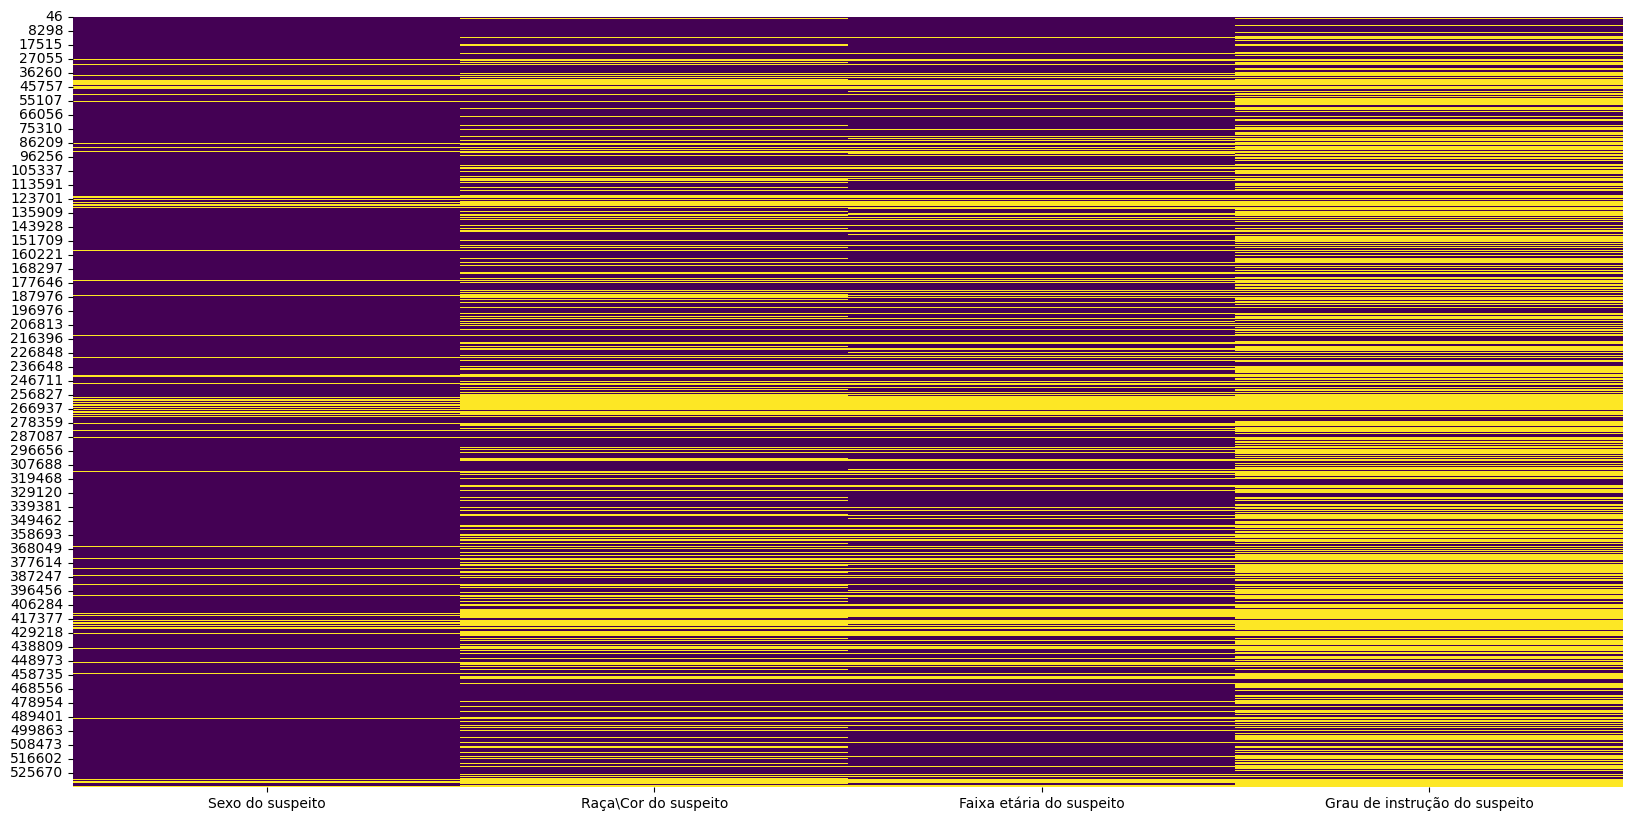

Linhas sem valores nulos: 9644/25180 (38.30%)


In [96]:
# Seleciona as colunas que serão utilizadas
dataSelectedKMeansTest4 = data[['Sexo do suspeito',
                                'Raça\\Cor do suspeito',
                                'Faixa etária do suspeito',
                                'Grau de instrução do suspeito']].copy()

# Visualização dos valores nulos com um heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(dataSelectedKMeansTest4.isnull(), cbar=False, cmap='viridis')
plt.show()

numeroDeLinhasComNulo = dataSelectedKMeansTest4.isnull().any(axis=1).sum()
numeroDeLinhasSemNulo = dataSelectedKMeansTest4.notnull().all(axis=1).sum()
totalDeLinhas = len(dataSelectedKMeansTest4)
print(f"Linhas sem valores nulos: {numeroDeLinhasSemNulo}/{totalDeLinhas} ({numeroDeLinhasSemNulo/totalDeLinhas:.2%})")

# Remove as linhas com valores nulos
dataSelectedKMeansTest4 = RemoveLinhasComNulos(dataSelectedKMeansTest4)

### Teste 4.1

**Codificação:** Binária

In [97]:
# Aplica a codificação Binária
codificador = ce.BinaryEncoder(cols=dataSelectedKMeansTest4.columns)
dataSelectedEncodedBinaryKMeansTest4_1 = codificador.fit_transform(dataSelectedKMeansTest4) 

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest4_1 = range(1, 10)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest4_1 = []
inertiaKMeansTest4_1 = []

In [98]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest4_1:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataSelectedEncodedBinaryKMeansTest4_1)
    inertiaRandomTest4_1.append(kmeans_random.inertia_)

In [99]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest4_1:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataSelectedEncodedBinaryKMeansTest4_1)
    inertiaKMeansTest4_1.append(kmeans_kmeans.inertia_)

In [100]:
inertiasKMeansTest4_1 = pd.DataFrame({
    "Random" : inertiaRandomTest4_1,
    "K-Means++" : inertiaKMeansTest4_1,
    "Número de Clusters" : numbersOfClustersKMeansTest4_1
})

# Visualização dos custos
figKMeansTest4_1 = px.line(
    inertiasKMeansTest4_1, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 4.1: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest4_1)} clusters. Dataset: {nomeDoArquivo}. Codificação: binária.  <br>"
        f"Linhas com nulo removidas. Colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução (apenas suspeito). Apenas RS."
    )
)

figKMeansTest4_1.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização",
)

figKMeansTest4_1.show()

In [101]:
modelKMeansTest4_1 = KMeans(n_clusters=4, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
modelKMeansTest4_1.fit(dataSelectedEncodedBinaryKMeansTest4_1)

labelsKMeansTest4_1 = modelKMeansTest4_1.labels_

### Teste 4.2

**Codificação:** One-Hot

In [102]:
# Aplica a codificação One-Hot
dataSelectedEncodedOneHotKMeansTest4_2 = pd.get_dummies(dataSelectedKMeansTest4)

# Definição de com quantos clusters será testado.
numbersOfClustersKMeansTest4_2 = range(1, 10)

# Vetores para armazenar os "custos" (medida quantitativa de quão bem os clusters foram formados em termos de homogeneidade interna) para o K-Means
inertiaRandomTest4_2 = []
inertiaKMeansTest4_2 = []

In [103]:
# Calculando a inertia para a inicialização 'random'
for clustersNumber in numbersOfClustersKMeansTest4_2:
    kmeans_random = KMeans(n_clusters=clustersNumber, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_random.fit(dataSelectedEncodedOneHotKMeansTest4_2)
    inertiaRandomTest4_2.append(kmeans_random.inertia_)

In [104]:
# Calculando a inertia para a inicialização 'k-means++'
for clustersNumber in numbersOfClustersKMeansTest4_2:
    kmeans_kmeans = KMeans(n_clusters=clustersNumber, init='k-means++', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
    kmeans_kmeans.fit(dataSelectedEncodedOneHotKMeansTest4_2)
    inertiaKMeansTest4_2.append(kmeans_kmeans.inertia_)

In [105]:
inertiasKMeansTest4_2 = pd.DataFrame({
    "Random" : inertiaRandomTest4_2,
    "K-Means++" : inertiaKMeansTest4_2,
    "Número de Clusters" : numbersOfClustersKMeansTest4_2
})

# Visualização dos custos
figKMeansTest4_2 = px.line(
    inertiasKMeansTest4_2, 
    x = "Número de Clusters", 
    y = ["Random", "K-Means++"], 
    title = (
        f"Teste 4.2: Método do Cotovelo para o KMeans com até {len(numbersOfClustersKMeansTest4_2)} clusters. Dataset: {nomeDoArquivo}. Codificação: One-Hot.  <br>"
        f"Linhas com nulo removidas. Colunas: Sexo, Raça\\Cor, Faixa Etária e Grau de Instrução (apenas suspeito). Apenas RS."
    )
)

figKMeansTest4_2.update_layout(
    xaxis_title="Número de Clusters",
    yaxis_title="Inércia",
    legend_title="Método de Inicialização",
)

figKMeansTest4_2.show()

In [106]:
modelKMeansTest4_2 = KMeans(n_clusters=4, init='random', random_state=42, n_init = 1, max_iter=300, algorithm = 'lloyd', verbose=0)
modelKMeansTest4_2.fit(dataSelectedEncodedOneHotKMeansTest4_2)

labelsKMeansTest4_2 = modelKMeansTest4_2.labels_

# Comparação dos Labels

In [107]:
# Comparação 1: KMeans com codificação binária com KMeans com codificação One-Hot
samePositionsTestKMeans1 = labelsKMeansTest1_1 == labelsKMeansTest1_2
samePositionsTestKMeans2 = labelsKMeansTest2_1 == labelsKMeansTest2_2
samePositionsTestKMeans3 = labelsKMeansTest3_1 == labelsKMeansTest3_2
samePositionsTestKMeans4 = labelsKMeansTest4_1 == labelsKMeansTest4_2

# Comparação 2: KModes com KMeans com codificação binaria
samePositionsTestKModes1KMeans1_1 = labelsKModesTest1 == labelsKMeansTest1_1
samePositionsTestKModes2KMeans2_1 = labelsKModesTest2 == labelsKMeansTest2_1
samePositionsTestKModes3KMeans3_1 = labelsKModesTest3 == labelsKMeansTest3_1
samePositionsTestKModes4KMeans4_1 = labelsKModesTest4 == labelsKMeansTest4_1

# Comparação 3: KModes com KMeans com codificação One-Hot
samePositionsTestKModes1KMeans1_2 = labelsKModesTest1 == labelsKMeansTest1_2
samePositionsTestKModes2KMeans2_2 = labelsKModesTest2 == labelsKMeansTest2_2
samePositionsTestKModes3KMeans3_2 = labelsKModesTest3 == labelsKMeansTest3_2
samePositionsTestKModes4KMeans4_2 = labelsKModesTest4 == labelsKMeansTest4_2

# Comparação 1
commonCountTestKMeans1 = np.sum(samePositionsTestKMeans1)
commonCountTestKMeans2 = np.sum(samePositionsTestKMeans2)
commonCountTestKMeans3 = np.sum(samePositionsTestKMeans3)
commonCountTestKMeans4 = np.sum(samePositionsTestKMeans4)

# Comparação 2
commonCountTestKModes1KMeans1_1 = np.sum(samePositionsTestKModes1KMeans1_1)
commonCountTestKModes2KMeans2_1 = np.sum(samePositionsTestKModes2KMeans2_1)
commonCountTestKModes3KMeans3_1 = np.sum(samePositionsTestKModes3KMeans3_1)
commonCountTestKModes4KMeans4_1 = np.sum(samePositionsTestKModes4KMeans4_1)

# Comparação 3
commonCountTestKModes1KMeans1_2 = np.sum(samePositionsTestKModes1KMeans1_2)
commonCountTestKModes2KMeans2_2 = np.sum(samePositionsTestKModes2KMeans2_2)
commonCountTestKModes3KMeans3_2 = np.sum(samePositionsTestKModes3KMeans3_2)
commonCountTestKModes4KMeans4_2 = np.sum(samePositionsTestKModes4KMeans4_2)

# Exibição dos resultados
print(f"Número de valores iguais nas mesmas posições KMeans Binário vs KMeans One-Hot Teste 1: {commonCountTestKMeans1}/{len(labelsKMeansTest1_1)} ({commonCountTestKMeans1/len(labelsKMeansTest1_1):.2%})")
print(f"Número de valores iguais nas mesmas posições KMeans Binário vs KMeans One-Hot Teste 2: {commonCountTestKMeans2}/{len(labelsKMeansTest2_1)} ({commonCountTestKMeans2/len(labelsKMeansTest2_1):.2%})")
print(f"Número de valores iguais nas mesmas posições KMeans Binário vs KMeans One-Hot Teste 3: {commonCountTestKMeans3}/{len(labelsKMeansTest3_1)} ({commonCountTestKMeans3/len(labelsKMeansTest3_1):.2%})")
print(f"Número de valores iguais nas mesmas posições KMeans Binário vs KMeans One-Hot Teste 4: {commonCountTestKMeans4}/{len(labelsKMeansTest4_1)} ({commonCountTestKMeans4/len(labelsKMeansTest4_1):.2%})")
print("\n")
print(f"Número de valores iguais nas mesmas posições KModes vs KMeans (Binário) Teste 1: {commonCountTestKModes1KMeans1_1}/{len(labelsKModesTest1)} ({commonCountTestKModes1KMeans1_1/len(labelsKModesTest1):.2%})")
print(f"Número de valores iguais nas mesmas posições KModes vs KMeans (Binário) Teste 2: {commonCountTestKModes2KMeans2_1}/{len(labelsKModesTest2)} ({commonCountTestKModes2KMeans2_1/len(labelsKModesTest2):.2%})")
print(f"Número de valores iguais nas mesmas posições KModes vs KMeans (Binário) Teste 3: {commonCountTestKModes3KMeans3_1}/{len(labelsKModesTest3)} ({commonCountTestKModes3KMeans3_1/len(labelsKModesTest3):.2%})")
print(f"Número de valores iguais nas mesmas posições KModes vs KMeans (Binário) Teste 4: {commonCountTestKModes4KMeans4_1}/{len(labelsKModesTest4)} ({commonCountTestKModes4KMeans4_1/len(labelsKModesTest4):.2%})")
print("\n")
print(f"Número de valores iguais nas mesmas posições KModes vs KMeans (One-Hot) Teste 1: {commonCountTestKModes1KMeans1_2}/{len(labelsKModesTest1)} ({commonCountTestKModes1KMeans1_2/len(labelsKModesTest1):.2%})")
print(f"Número de valores iguais nas mesmas posições KModes vs KMeans (One-Hot) Teste 2: {commonCountTestKModes2KMeans2_2}/{len(labelsKModesTest2)} ({commonCountTestKModes2KMeans2_2/len(labelsKModesTest2):.2%})")
print(f"Número de valores iguais nas mesmas posições KModes vs KMeans (One-Hot) Teste 3: {commonCountTestKModes3KMeans3_2}/{len(labelsKModesTest3)} ({commonCountTestKModes3KMeans3_2/len(labelsKModesTest3):.2%})")
print(f"Número de valores iguais nas mesmas posições KModes vs KMeans (One-Hot) Teste 4: {commonCountTestKModes4KMeans4_2}/{len(labelsKModesTest4)} ({commonCountTestKModes4KMeans4_2/len(labelsKModesTest4):.2%})")

Número de valores iguais nas mesmas posições KMeans Binário vs KMeans One-Hot Teste 1: 3165/4324 (73.20%)
Número de valores iguais nas mesmas posições KMeans Binário vs KMeans One-Hot Teste 2: 3843/9314 (41.26%)
Número de valores iguais nas mesmas posições KMeans Binário vs KMeans One-Hot Teste 3: 6363/15982 (39.81%)
Número de valores iguais nas mesmas posições KMeans Binário vs KMeans One-Hot Teste 4: 4926/9644 (51.08%)


Número de valores iguais nas mesmas posições KModes vs KMeans (Binário) Teste 1: 1264/4324 (29.23%)
Número de valores iguais nas mesmas posições KModes vs KMeans (Binário) Teste 2: 2434/9314 (26.13%)
Número de valores iguais nas mesmas posições KModes vs KMeans (Binário) Teste 3: 2706/15982 (16.93%)
Número de valores iguais nas mesmas posições KModes vs KMeans (Binário) Teste 4: 2828/9644 (29.32%)


Número de valores iguais nas mesmas posições KModes vs KMeans (One-Hot) Teste 1: 1722/4324 (39.82%)
Número de valores iguais nas mesmas posições KModes vs KMeans (One-Hot

# Processamento das imagens

In [ ]:
# Carregar as imagens
KModesTeste1 = Image.open('KModesTeste1.png')
KModesTeste2 = Image.open('KModesTeste2.png')
KModesTeste3 = Image.open('KModesTeste3.png')
KModesTeste4 = Image.open('KModesTeste4.png')

# Unir imagens verticalmente
larguraMaxima = KModesTeste1.width
alturaTotal = 4*KModesTeste1.height

novaImagem = Image.new('RGB', (larguraMaxima, alturaTotal))
novaImagem.paste(KModesTeste1, (0, 0))
novaImagem.paste(KModesTeste2, (0, KModesTeste1.height))
novaImagem.paste(KModesTeste3, (0, 2*KModesTeste1.height))
novaImagem.paste(KModesTeste4, (0, 3*KModesTeste1.height))

# Salvar as novas imagens
novaImagem.save('Testes de Cotovelo KModes.jpg')


In [125]:
# Carregar as imagens
KMeansTeste1_1 = Image.open('KMeansTeste1.1.png')
KMeansTeste1_2 = Image.open('KMeansTeste1.2.png')
KMeansTeste2_1 = Image.open('KMeansTeste2.1.png')
KMeansTeste2_2 = Image.open('KMeansTeste2.2.png')
KMeansTeste3_1 = Image.open('KMeansTeste3.1.png')
KMeansTeste3_2 = Image.open('KMeansTeste3.2.png')
KMeansTeste4_1 = Image.open('KMeansTeste4.1.png')
KMeansTeste4_2 = Image.open('KMeansTeste4.2.png')

# Unir imagens verticalmente
larguraMaxima = 2*KMeansTeste1_1.width
alturaTotal = 4*KMeansTeste1_1.height

novaImagem = Image.new('RGB', (larguraMaxima, alturaTotal))

novaImagem.paste(KMeansTeste1_1, (0, 0))
novaImagem.paste(KMeansTeste1_2, (KMeansTeste1_1.width, 0))

novaImagem.paste(KMeansTeste2_1, (0, KMeansTeste1_1.height))
novaImagem.paste(KMeansTeste2_2, (KMeansTeste1_1.width, KMeansTeste1_1.height))

novaImagem.paste(KMeansTeste3_1, (0, 2*KMeansTeste1_1.height))
novaImagem.paste(KMeansTeste3_2, (KMeansTeste1_1.width, 2*KMeansTeste1_1.height))

novaImagem.paste(KMeansTeste4_1, (0, 3*KMeansTeste1_1.height))
novaImagem.paste(KMeansTeste4_2, (KMeansTeste1_1.width, 3*KMeansTeste1_1.height))

# Salvar as novas imagens
novaImagem.save('Testes de Cotovelo KMeans.jpg')
